In [81]:
import copy
import csv
import logging
import sys
import time
import warnings

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.metrics import r2_score

import pypsa
from n_dimensional_datasets import *
from plotter import *

from IPython.display import display # for better Pandas printing 

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = path_to_powerflow_example + "/ieee-13-with-load-gen/"
path_to_powerflow_results = path_to_powerflow_data + "results/"

sys.path.append(path_to_powerflow_example)
from ieee13_pf import run

from change_powerflow_data import set_sample_size

def reject_outliers(data, m=3, return_positions=False):
    positions = abs(data - np.mean(data)) < m * np.std(data)
    if return_positions:
        return positions
    return data[positions]

## data sampling

In [82]:
n_original_samples = 2

if n_original_samples < 2:
    raise ValueError("n_original_samples must be an integer >1")

sample_size = 10000

In [83]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name +  "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)

def collect_data(data):
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_results + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_results + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_results + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_results + "linemags.csv"), "linemag")

With the linear load flow, there is the following per unit loading:
count    11.000000
mean      0.301489
std       0.213053
min       0.000000
25%       0.161390
50%       0.221734
75%       0.425876
max       0.776534
dtype: float64


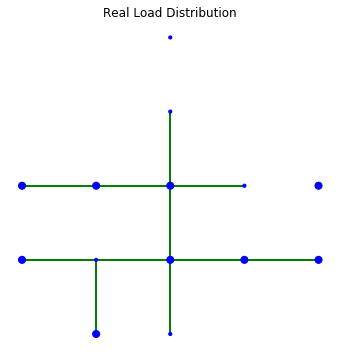

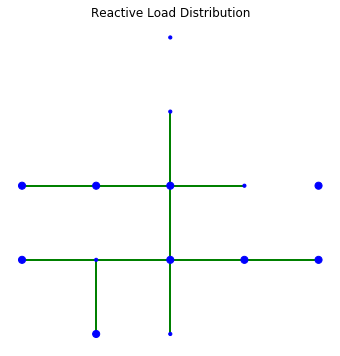

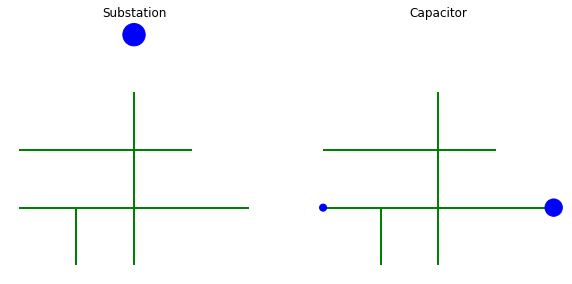

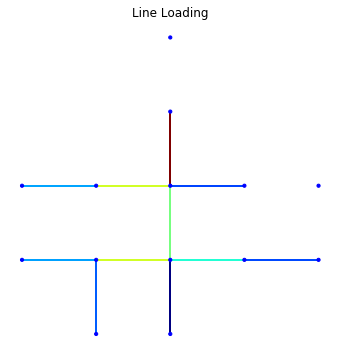

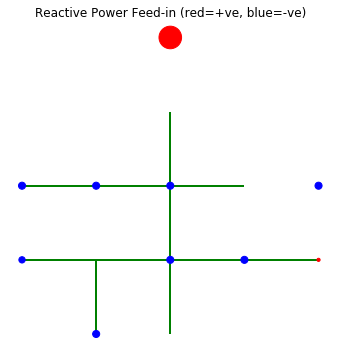

In [84]:
data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

# set_sample_size(path_to_powerflow_data, data_to_change, sample_size, n_original_samples, seed=None)
# network = run() # savefig=["real-loading", ""reactive-loading", "generation", "line-loading", "reactive-feedin"]


data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(data)

## train

In [85]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import LinearNDInterpolator
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from custom_transformers import DataFrameSelector, RejectOutliers
from sklearn.decomposition import PCA
from scoring import rmse

In [86]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1) #loc[:,["vmag-632", "vmag-671", "vmag-675"]]
features_and_labels = features.join(labels)

In [87]:
# data transformations

all_pipeline = Pipeline([
    ("outliers", RejectOutliers(labels.columns)),
])

features_and_labels = pd.DataFrame(all_pipeline.fit_transform(features_and_labels)) 
features = features_and_labels[[col for col in features_and_labels if 'load' in col]]
labels = features_and_labels[[col for col in features_and_labels if 'vmag' in col]]

feature_pipeline = Pipeline([
#     ("selector", DataFrameSelector(["load-671", "load-675"])),
    ("pca", PCA()),
#     ("scaler", StandardScaler()),
])
feature_pipeline.set_params(pca__n_components=0.95)

attributes = list(labels.keys())
attributes.remove("vmag-634")
attributes.remove("vmag-650")
label_pipeline = Pipeline([
    ("selector", DataFrameSelector(attributes))
])

features = pd.DataFrame(feature_pipeline.fit_transform(features)) #columns=features.columns
labels = pd.DataFrame(label_pipeline.fit_transform(labels), columns=attributes)

In [88]:
training_percentage = 80
n_samples = features.shape[0]
n_training_samples = int(n_samples*(training_percentage/100))

random_seed=0
X_train = features.sample(n_training_samples, random_state=random_seed)
y_train = labels.sample(n_training_samples, random_state=random_seed)
X_val = features[~features.isin(X_train)].dropna()
y_val = labels[~labels.isin(y_train)].dropna()

X_train = X_train.values
y_train = y_train.values
X_val = X_val.values
y_val = y_val.values

In [89]:
training_stats = {"n_training_samples": n_training_samples,
                  "n_validation_samples": n_samples-n_training_samples,
                  "n_features": X_train.shape[1],
                  "n_labels": y_train.shape[1],
                  "interp_run": False}
stats = {"trainscore": [], 
         "trainscorevar": [],
         "valscore": [],
         "valscorevar": [],
         "rmse": [],
         "time": []}
approx_type = {"svr": copy.deepcopy(stats),
               "rf": copy.deepcopy(stats),
               "ann": copy.deepcopy(stats),
               "interp": copy.deepcopy(stats)}
approx_type["interp"].pop("trainscorevar")
approx_type["interp"].pop("valscorevar")


time_start = time.time()
### setup approximators


## random forest
forest = RandomForestRegressor()

forest_xval_training_score = reject_outliers(cross_val_score(forest, X_train, y_train, cv=5, n_jobs=-1, scoring=make_scorer(r2_score)))
forest_xval_val_score = reject_outliers(cross_val_score(forest, X_val, y_val, cv=5, n_jobs=-1, scoring=make_scorer(r2_score)))
approx_type["rf"]["trainscore"].append(forest_xval_training_score.mean())
approx_type["rf"]["trainscorevar"].append(forest_xval_training_score.std())
approx_type["rf"]["valscore"].append(forest_xval_val_score.mean())
approx_type["rf"]["valscorevar"].append(forest_xval_val_score.std())

forest.fit(X_train, y_train)
approx_type["rf"]["rmse"].append(rmse(forest.predict(X_val), y_val))

time_forest = time.time()
approx_type["rf"]["time"].append(time_forest-time_start)

                                
## support vector regression
n_labels = y_train.shape[1]
svr = copy.deepcopy(stats)
svr_labels = {"y_train": None, "y_val": None}
for idx in range(n_labels):
    svr_labels["y_train"] = y_train.T[idx].T
    svr_labels["y_val"] = y_val.T[idx].T
    clf = SVR(gamma='scale', C=1.0, epsilon=0.0002, kernel='linear')
    '''
    Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function
    (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), 
    which is why the preceding code computes -scores before calculating the square root.
    - A. Geron, Hands on Machine Learning pg 101 
    '''
    svr_xval_training_score = reject_outliers(cross_val_score(clf, X_train, svr_labels["y_train"], cv=5, n_jobs=-1, scoring=make_scorer(r2_score)))
    svr_xval_val_score = reject_outliers(cross_val_score(clf, X_val, svr_labels["y_val"], cv=5, n_jobs=-1, scoring=make_scorer(r2_score)))    
    svr["trainscore"].append(svr_xval_training_score.mean())
    svr["trainscorevar"].append(svr_xval_training_score.std())
    svr["valscore"].append(svr_xval_val_score.mean())
    svr["valscorevar"].append(svr_xval_val_score.std())

    clf.fit(X_train, svr_labels["y_train"])
    svr["rmse"].append(rmse(clf.predict(X_val), svr_labels["y_val"]))

    time_svr = time.time()
    svr["time"].append(time_svr - time_forest)
    
    if idx == (n_labels-1):
        display("rmse: ", svr["rmse"])
        label_results = pd.DataFrame(columns=labels.columns)
        label_results.loc[0] = svr["trainscore"]
        display(label_results)

approx_type["svr"]["trainscore"].append(np.mean(svr["trainscore"]))
approx_type["svr"]["trainscorevar"].append(np.mean(svr["trainscorevar"]))
approx_type["svr"]["valscore"].append(np.mean(svr["valscore"]))
approx_type["svr"]["valscorevar"].append(np.mean(svr["valscorevar"]))
approx_type["svr"]["rmse"].append(np.mean(svr["rmse"]))
approx_type["svr"]["time"].append(np.mean(svr["time"]))


## ann
hidden_layer_size = 5
ann = MLPRegressor(hidden_layer_sizes=(hidden_layer_size,),
#                    activation="relu",
                   solver="lbfgs",
                   alpha=0.001,
                   learning_rate_init=0.00000001,
                   tol=1e-6,
                   n_iter_no_change=1000
                  )

ann_xval_training_score = reject_outliers(cross_val_score(ann, X_train, y_train, cv=5, n_jobs=-1, scoring=make_scorer(r2_score)))
ann_xval_val_score = reject_outliers(cross_val_score(ann, X_val, y_val, cv=5, n_jobs=-1, scoring=make_scorer(r2_score)))
approx_type["ann"]["trainscore"].append(ann_xval_training_score.mean())
approx_type["ann"]["trainscorevar"].append(ann_xval_training_score.std())
approx_type["ann"]["valscore"].append(ann_xval_val_score.mean())
approx_type["ann"]["valscorevar"].append(ann_xval_val_score.std())
print("\n\nANN training scores: {}\n\n val scores: {}".format(ann_xval_training_score, ann_xval_val_score))

ann.fit(X_train, y_train)
approx_type["ann"]["rmse"].append(rmse(ann.predict(X_val), y_val))

time_ann = time.time()
approx_type["ann"]["time"].append(time_ann-time_svr)


## interpolation
# interp training gets very slow as the number of features grows
if X_train.shape[1] < 4:
    training_stats["interp_run"] = True
    interp = LinearNDInterpolator(X_train, y_train, fill_value=0)

    time_interp = time.time()
    approx_type["interp"]["time"].append(time_interp-time_ann)

    approx_type["interp"]["trainscore"].append(r2_score(y_train, interp(X_train)))
    approx_type["interp"]["valscore"].append(r2_score(y_val, interp(X_val)))
    approx_type["interp"]["rmse"].append(rmse(interp(X_val), y_val))


## print stats
print("Training Stats\n\n{}".format(pd.DataFrame(training_stats, index=[0])))
for t in approx_type:
    print("\n", t + " Stats: \n")
    display(pd.DataFrame(approx_type[t]).round(3))

print("svr training score - non crossvalidation: ", r2_score(svr_labels["y_train"], clf.predict(X_train)))
print("svr validation score - non crossvalidation: ", r2_score(svr_labels["y_val"], clf.predict(X_val)))
print("rf training score - non crossvalidation: ", r2_score(y_train, forest.predict(X_train)))
print("rf validation score - non crossvalidation: ", r2_score(y_val, forest.predict(X_val)))
print("ann training score - non crossvalidation: ", r2_score(y_train, ann.predict(X_train)))
print("ann validation score - non crossvalidation: ", r2_score(y_val, ann.predict(X_val)))

'rmse: '

[0.022380134608289783,
 0.022092111573965987,
 0.02109935598999912,
 0.02134006665900097,
 0.023907174926457785,
 0.023600480314052385,
 0.022892251972510935,
 0.022892691313968563,
 0.02304291394137792,
 0.02442144481894947,
 0.022895252787845002]

,vmag-646,vmag-645,vmag-632,vmag-633,vmag-611,vmag-684,vmag-671,vmag-692,vmag-675,vmag-652,vmag-680
0,0.494273,0.445748,0.300485,0.333712,0.584232,0.551229,0.489539,0.489517,0.509632,0.631404,0.489555




ANN training scores: [0.47451002 0.4717771  0.40704757 0.42307984 0.43789897]

 val scores: [0.42778253 0.39942382 0.38927322 0.44948046 0.43250779]
Training Stats

   n_training_samples  n_validation_samples  n_features  n_labels  interp_run
0                7832                  1959           9        11       False

 svr Stats: 



,trainscore,trainscorevar,valscore,valscorevar,rmse,time
0,0.484,0.026,0.453,0.033,0.023,204.394



 rf Stats: 



,trainscore,trainscorevar,valscore,valscorevar,rmse,time
0,0.374,0.023,0.347,0.039,0.025,4.785



 ann Stats: 



,trainscore,trainscorevar,valscore,valscorevar,rmse,time
0,0.443,0.027,0.42,0.022,0.024,1.735



 interp Stats: 



,trainscore,valscore,rmse,time


svr training score - non crossvalidation:  0.4917544268455797
svr validation score - non crossvalidation:  0.46151874061986065
rf training score - non crossvalidation:  0.8903034462753361
rf validation score - non crossvalidation:  0.3723698995352441
ann training score - non crossvalidation:  0.44461892400306996
ann validation score - non crossvalidation:  0.417358986248262


In [90]:
# plotting
from plotter import plot3d_approximation

if X_train.shape[1] == 1:
    plt.plot(X_train, clf.predict(X_train), "x", X_train, y_train, "o")
    plt.show()

    plt.figure()
    plt.plot(X_val, clf.predict(X_val), "x", X_val, y_val, "o")
    plt.show()
    
elif X_train.shape[1] == 2:
    plot3d_approximation(X_train.T, y_train, clf.predict(X_train))

In [91]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(forest, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm) #feature_names=features.columns.tolist()

Weight,Feature
0.6699 ± 0.0540,x8
0.0595 ± 0.0117,x3
0.0506 ± 0.0197,x2
0.0292 ± 0.0098,x6
0.0246 ± 0.0147,x1
0.0137 ± 0.0137,x4
0.0128 ± 0.0175,x5
0.0072 ± 0.0071,x0
0.0041 ± 0.0065,x7
